## Inspect dictionary decomposition

We are solving Non-negative Sparse Coding by alternating minimization.

We solve
$$
        \min_{U > 0} ||U V^T - X||^2 + \gamma * (||U||_1) \\
                s.t. ||V[i, :]||_2 =< 1 \text{ for all i}
$$

Below, we inspect these solutions for various values of $\gamma$. One problem that is apparent is that if $\gamma$ is too small, the solution is not sparse. If $\gamma$ is too large, the solution is too sparse, and in fact many dictionary elements are zero and totally unused. We need to find a good value of $\gamma$ that balances these two extremes.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
import os

def load_geneformer_embeddings(path, reordered=True, brain=True):
    if brain:
        path = os.path.join(path, "geneformer", "gene_embeddings_ordered_brain.json")
    elif reordered:
        path = os.path.join(path, "geneformer", "gene_embeddings_ordered.json")
    else:
        path = os.path.join(path, "geneformer", "gene_embeddings_big.json")
    embeddings_dict = json.load(open(path))
    all_genes = list(embeddings_dict.keys())
    embeddings = np.array([embeddings_dict[gene] for gene in all_genes])
    return np.array(embeddings), list(all_genes)

In [39]:

path = "/home/benjami/mnt/zador_data_norepl/lambda-storage/nfs-scratch-1/scratch-1/benjami/barseq-transformer/gene_embeddings/dictionary_decomposition/"

V = np.load(os.path.join(path,"V_5e-05_ball_10000.npy"))
U = np.load(os.path.join(path,"U_5e-05_ball_10000.npy"))

U.shape, V.shape

((25426, 10000), (512, 10000))

Inspect the genes in each element.

In [19]:
emb_path = "/home/benjami/gene_analogies/data"
embeddings, genes = load_geneformer_embeddings(emb_path, reordered=False, brain=False)
len(genes)

25426

In [20]:
descriptions = json.load(open(os.path.join(emb_path, "geneformer", "gene_descriptions.json")))

In [48]:
row_normalized_U = U / np.sum(U, axis=1, keepdims=True)

In [51]:
# For each eigengene (a row in V or U), I want to list out the genes that are most similar to it
# I'd like to do that for all of the eigengenes in V and U,
# and I'd also like the capability to choose a gene and then list the eigengenes that are most similar to it, and
# also the genes in each eigengene family

genes_to_see = 10
modules_to_see = 3
query_gene = "ENSG00000206172"
query_gene_idx = genes.index(query_gene)

for i in range(modules_to_see):
        
    # Find the eigengene that is most similar to the query gene
    top_module = np.argsort(row_normalized_U[query_gene_idx, :])[-(i+1)]
    participation = row_normalized_U[query_gene_idx, top_module]

    # Find the k genes that are most similar to the top module
    top_genes_idx = np.argsort(row_normalized_U[:, top_module])[-genes_to_see:][::-1]
    top_genes = [genes[j] for j in top_genes_idx]
    gene_participations = row_normalized_U[top_genes_idx, top_module]

    print(f"Top modules for {query_gene} ({descriptions.get(query_gene,'N/A')})")
    print(f"\nModule: {top_module} with participation {participation}")
    print("| Gene | Participation | Description |")
    for gene, participation in zip(top_genes, gene_participations):
        print(f"| {gene} | {participation} | {descriptions.get(gene,'N/A')} |")




Top modules for ENSG00000206172 (hemoglobin subunit alpha 1 [Source:HGNC Symbol;Acc:HGNC:4823])

Module: 6650 with participation 0.19863036274909973
| Gene | Participation | Description |
| ENSG00000164597 | 0.7210806012153625 | component of oligomeric golgi complex 5 [Source:HGNC Symbol;Acc:HGNC:14857] |
| ENSG00000243251 | 0.6425058841705322 | None |
| ENSG00000004897 | 0.6345046162605286 | cell division cycle 27 [Source:HGNC Symbol;Acc:HGNC:1728] |
| ENSG00000077254 | 0.6022752523422241 | ubiquitin specific peptidase 33 [Source:HGNC Symbol;Acc:HGNC:20059] |
| ENSG00000104765 | 0.541835606098175 | BCL2 interacting protein 3 like [Source:HGNC Symbol;Acc:HGNC:1085] |
| ENSG00000266507 | 0.5376381278038025 | microRNA 4479 [Source:HGNC Symbol;Acc:HGNC:41767] |
| ENSG00000265902 | 0.5320048928260803 | microRNA 4696 [Source:HGNC Symbol;Acc:HGNC:41780] |
| ENSG00000276368 | 0.5299144387245178 | H2A clustered histone 14 [Source:HGNC Symbol;Acc:HGNC:4727] |
| ENSG00000112539 | 0.5240697860717

In [50]:
genes_to_see = 10
modules_to_see = 10

# Rank the eigengenes by the maximum participation of any gene in them
module_participations = np.max(row_normalized_U, axis=0)
top_modules = np.argsort(module_participations)[-modules_to_see:][::-1]

for i in top_modules:

    if np.sum(row_normalized_U[:, i]) == 0:
        continue
        
    # Find the k genes that are most similar to this module
    top_genes_idx = np.argsort(row_normalized_U[:, i])[-genes_to_see:][::-1]
    top_genes = [genes[j] for j in top_genes_idx]
    gene_participations = row_normalized_U[top_genes_idx, i]

    print(f"\nModule: {i}")
    print("| Gene | Participation | Description |")
    for gene, participation in zip(top_genes, gene_participations):
        print(f"| {gene} | {participation} | {descriptions.get(gene,'N/A')} |")


Module: 5575
| Gene | Participation | Description |
| ENSG00000090447 | 0.9283193945884705 | transcription factor AP-4 [Source:HGNC Symbol;Acc:HGNC:11745] |
| ENSG00000258223 | 0.27384448051452637 | serine protease 58 [Source:HGNC Symbol;Acc:HGNC:39125] |
| ENSG00000265134 | 0.26842084527015686 | microRNA 3190 [Source:HGNC Symbol;Acc:HGNC:38190] |
| ENSG00000264085 | 0.26065167784690857 | None |
| ENSG00000263584 | 0.24550721049308777 | microRNA 4480 [Source:HGNC Symbol;Acc:HGNC:41716] |
| ENSG00000111412 | 0.23935703933238983 | SREBF pathway regulator in golgi 1 [Source:HGNC Symbol;Acc:HGNC:26128] |
| ENSG00000172354 | 0.2291201800107956 | G protein subunit beta 2 [Source:HGNC Symbol;Acc:HGNC:4398] |
| ENSG00000135624 | 0.2269056737422943 | chaperonin containing TCP1 subunit 7 [Source:HGNC Symbol;Acc:HGNC:1622] |
| ENSG00000170500 | 0.2219546139240265 | LON peptidase N-terminal domain and ring finger 2 [Source:HGNC Symbol;Acc:HGNC:24788] |
| ENSG00000186115 | 0.21744757890701294 | cy

Text(0.5, 1.0, 'Norm of rows in the eigengenes V')

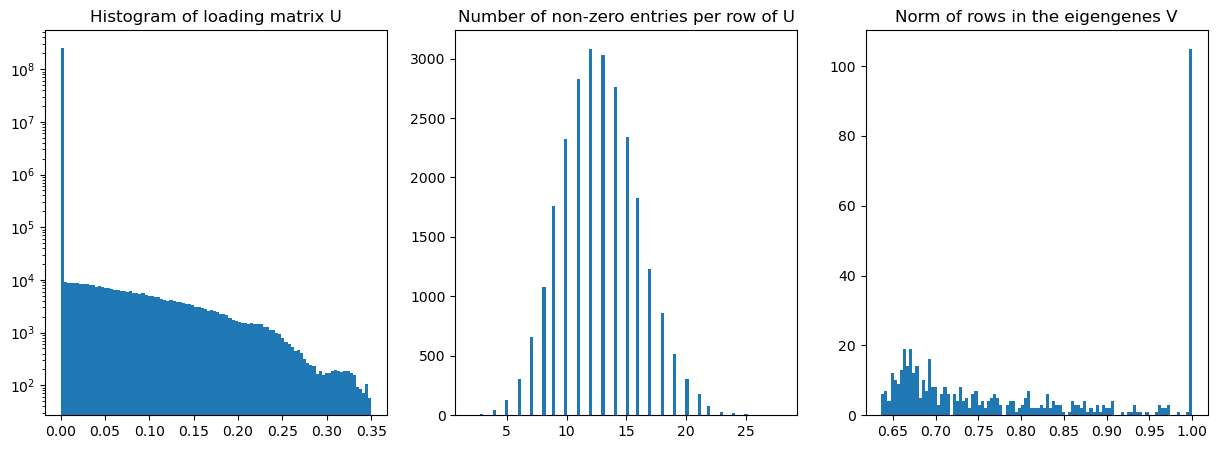

In [42]:
f,axs = plt.subplots(1,3,figsize=(15,5))

axs[0].hist(U.flatten(), bins=100);
axs[0].set_yscale("log")
axs[0].set_title("Histogram of loading matrix U")
axs[1].hist(np.count_nonzero(U, axis=1), bins=100);
axs[1].set_title("Number of non-zero entries per row of U")
axs[2].hist(np.linalg.norm(V, axis=1), bins=100);
axs[2].set_title("Norm of rows in the eigengenes V")


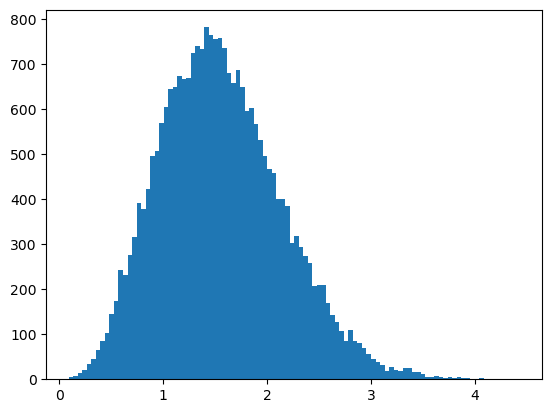

In [43]:
X = U @ V.T
plt.hist(np.linalg.norm(X, axis=1), bins=100);  

Text(0.5, 1.0, 'Number of used vectors in U: 234 out of 1000')

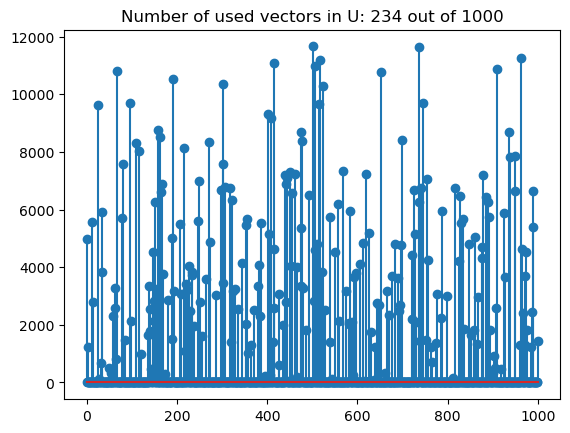

In [6]:
plt.stem(np.count_nonzero(U,0))
plt.title(f"Number of used vectors in U: {np.count_nonzero(U.sum(0))} out of {U.shape[1]}")

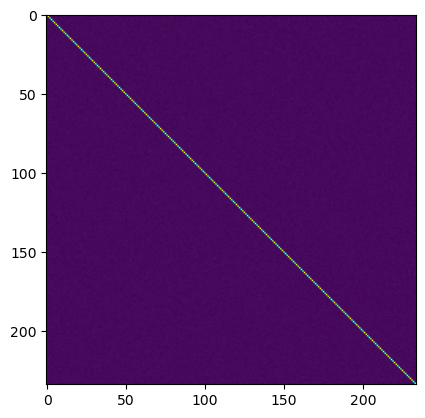

In [7]:
is_used = np.count_nonzero(U,0) > 0
U_used = U[:,is_used]
V_used = V[:,is_used]

corr = np.corrcoef(U_used, rowvar=False)
plt.imshow(corr, cmap="viridis")

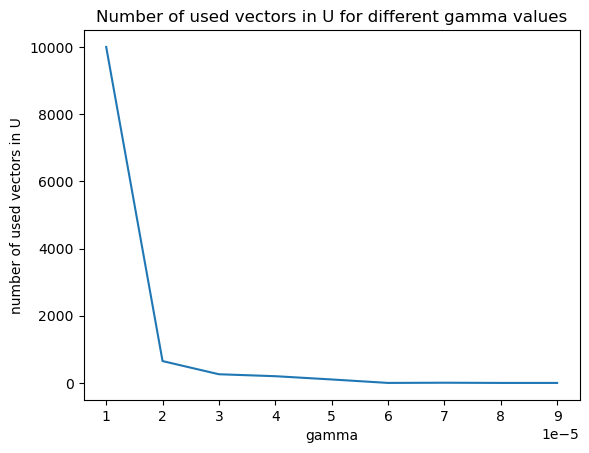

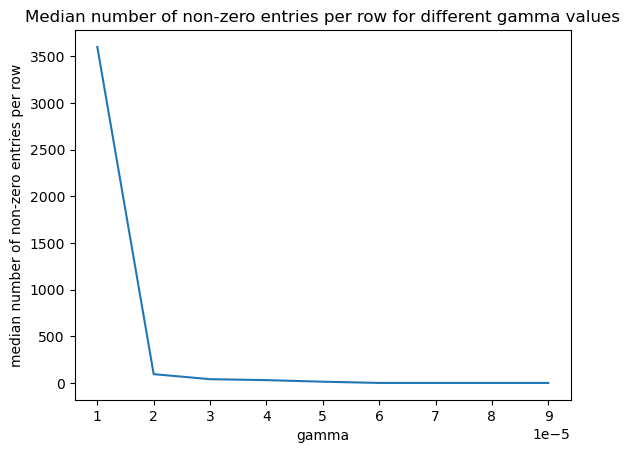

/tmp/ipykernel_1347957/2060810618.py:26: RuntimeWarning: invalid value encountered in divide
  plt.plot(gammas, np.array(medians_loadings)/(np.array(n_useds)))


Text(0.5, 1.0, 'Ratio of used vectors in U to number of non-zero entries per row')

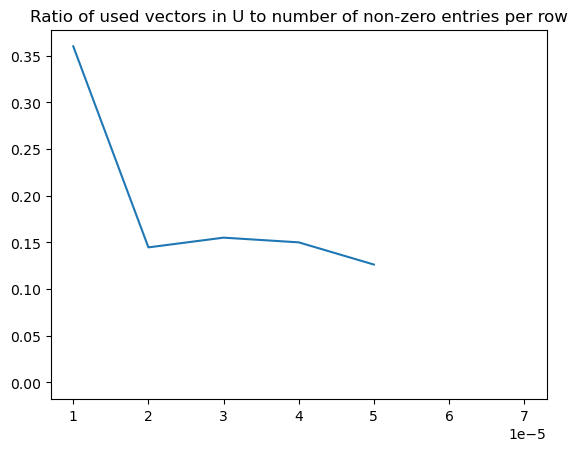

In [37]:
gammas = np.linspace(0.00001,0.00009,9)
n_useds = []
medians_loadings = []

for gamma in gammas:
    gamma = np.round(gamma, 5)
    U = np.load(os.path.join(path,f"U_{gamma}_ball_10000.npy"))
    n_used = np.count_nonzero(U.sum(0))
    n_useds.append(n_used)

    median_cell_loadings = np.median(np.count_nonzero(U, axis=1))
    medians_loadings.append(median_cell_loadings)

plt.plot(gammas, n_useds)
plt.xlabel("gamma")
plt.ylabel("number of used vectors in U")   
plt.title("Number of used vectors in U for different gamma values")
plt.show()

plt.plot(gammas, medians_loadings)
plt.xlabel("gamma")
plt.ylabel("median number of non-zero entries per row")
plt.title("Median number of non-zero entries per row for different gamma values")
plt.show()

plt.plot(gammas, np.array(medians_loadings)/(np.array(n_useds)))
plt.title("Ratio of used vectors in U to number of non-zero entries per row")